In [1]:
import sys
sys.path.append("../")

from CurveDataFetcher import CurveDataFetcher 
from HedgeHog import ols_hedge_ratio, hedge_hog

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from utils.pca import run_pca_yield_curve, create_residuals_surface_plot, plot_residuals_for_date
from utils.viz import plot_usts, plot_timeseries, plot_residuals_timeseries, plot_mr_residuals_timeseries, run_basic_linear_regression_df, run_basic_linear_regression

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Curvy-CUSIPs\notebooks\../.env


In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [26]:
ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(start_date=datetime(2023, 1, 1), end_date=datetime(2023, 9, 23))
ct_yields_df 

,Date,CT2M,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
0,2023-01-03,NaN,4.684165,4.781151,4.722890,4.399092,4.192135,3.937598,3.885265,3.787320,4.057251,3.884048
1,2023-01-04,NaN,4.662971,4.749067,4.711754,4.365910,4.123733,3.854067,3.787677,3.693511,3.967547,3.809364
2,2023-01-05,NaN,4.725342,4.819400,4.787549,4.449214,4.192343,3.902711,3.823493,3.712084,3.960694,3.785325
3,2023-01-06,NaN,4.693085,4.786811,4.721529,4.249257,3.975516,3.694481,3.634544,3.552079,3.843300,3.672193
4,2023-01-09,NaN,4.682341,4.807567,4.699546,4.199130,3.941264,3.666756,3.598982,3.529844,3.825433,3.663856
...,...,...,...,...,...,...,...,...,...,...,...,...
176,2023-09-18,NaN,5.548917,5.504330,5.446270,5.065025,4.737937,4.459273,4.408905,4.316090,4.577031,4.392589
177,2023-09-19,NaN,5.572830,5.503910,5.456946,5.099119,4.794811,4.516350,4.467651,4.364212,4.616385,4.429782
178,2023-09-20,NaN,5.572404,5.503491,5.478623,5.133331,4.817655,4.523523,4.457043,4.344256,4.586850,4.392595
179,2023-09-21,NaN,5.571978,5.503072,5.467298,5.133364,4.851980,4.609603,4.569813,4.481466,4.753747,4.555516


In [43]:
labels = ["3.125% Nov-41", "2.000% Nov-41"] 
cusip_1 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(ust_label=labels[0])["cusip"]
cusip_2 = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(ust_label=labels[1])["cusip"]
# nov_50s_cusip = curve_data_fetcher.ust_data_fetcher.ust_label_to_cusip(ust_label=labels[2])["cusip"]
cusips_df = curve_data_fetcher.fedinvest_data_fetcher.cusips_timeseries(
    cusips=[cusip_1, cusip_2], start_date=datetime(2024, 1, 1), end_date=datetime(2024, 10, 1), to_df_col="eod_yield", use_dict_key_df_cols=True,
)
cusips_df.columns = ["Date"] + labels
cusips_df

,Date,3.125% Nov-41,2.000% Nov-41
0,2024-01-02,4.206862,4.261942
1,2024-01-03,4.174182,4.228607
2,2024-01-04,4.264913,4.317918
3,2024-01-05,4.334850,4.390368
4,2024-01-08,4.293138,4.346974
...,...,...,...
186,2024-09-25,4.084584,4.193426
187,2024-09-26,4.079262,4.184606
188,2024-09-27,4.043889,4.148461
189,2024-09-30,4.090762,4.188828


In [41]:
# window_size = 20
# x_cols=["CT2"]
# y_col="CT5"

# x_errs = ct_yields_df[x_cols].rolling(window=window_size).std()

# y_errs = ct_yields_df[y_col].rolling(window=window_size).std()
# df = ct_yields_df.iloc[window_size - 1:]
# x_errs = x_errs.iloc[window_size - 1:]
# y_errs = y_errs.iloc[window_size - 1:]

# x_errs_array = x_errs.values.T
# y_errs_array = y_errs.values

hh = hedge_hog(
    df=cusips_df,
    # run_on_percent_changes=True,
    # run_on_level_changes=True,
    x_cols=["3.125% Nov-41"],
    y_col="2.000% Nov-41", 
    # x_errs=x_errs_array, 
    # y_errs=y_errs_array, 
    run_pca_on_corr_mat=True
)

In [42]:
# print("odr: ", hh["odr"].beta)
print("tls: ", [f"{b:3f}" for b in hh["tls"].beta])
print("ols: ", [f"{b:3f}" for b in hh["ols"].params.values])
# print("mvlsr_ols: ", [f"{b:3f}" for b in hh["mvlsr_ols"].params.values])
# print("pcr:", hh["pcr"].params)
# print("pca: ", hh["pca"])
print("pca_loadings_df: \n", hh["pca_loadings_df"])
print(hh["ols"].summary())

tls:  ['0.441151', '0.910566']
ols:  ['0.445364', '0.909620']
pca_loadings_df: 
                    PC_1      PC_2
3.125% Nov-41  0.707107  0.707107
2.000% Nov-41  0.707107 -0.707107
                            OLS Regression Results                            
Dep. Variable:          2.000% Nov-41   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 8.233e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):          1.88e-251
Time:                        14:39:35   Log-Likelihood:                 599.90
No. Observations:                 191   AIC:                            -1196.
Df Residuals:                     189   BIC:                            -1189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef   

                            OLS Regression Results                            
Dep. Variable:                   CT30   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     9510.
Date:                Wed, 16 Oct 2024   Prob (F-statistic):           4.54e-79
Time:                        16:41:08   Log-Likelihood:                 218.00
No. Observations:                  75   AIC:                            -432.0
Df Residuals:                      73   BIC:                            -427.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4778      0.018     26.297      0.0

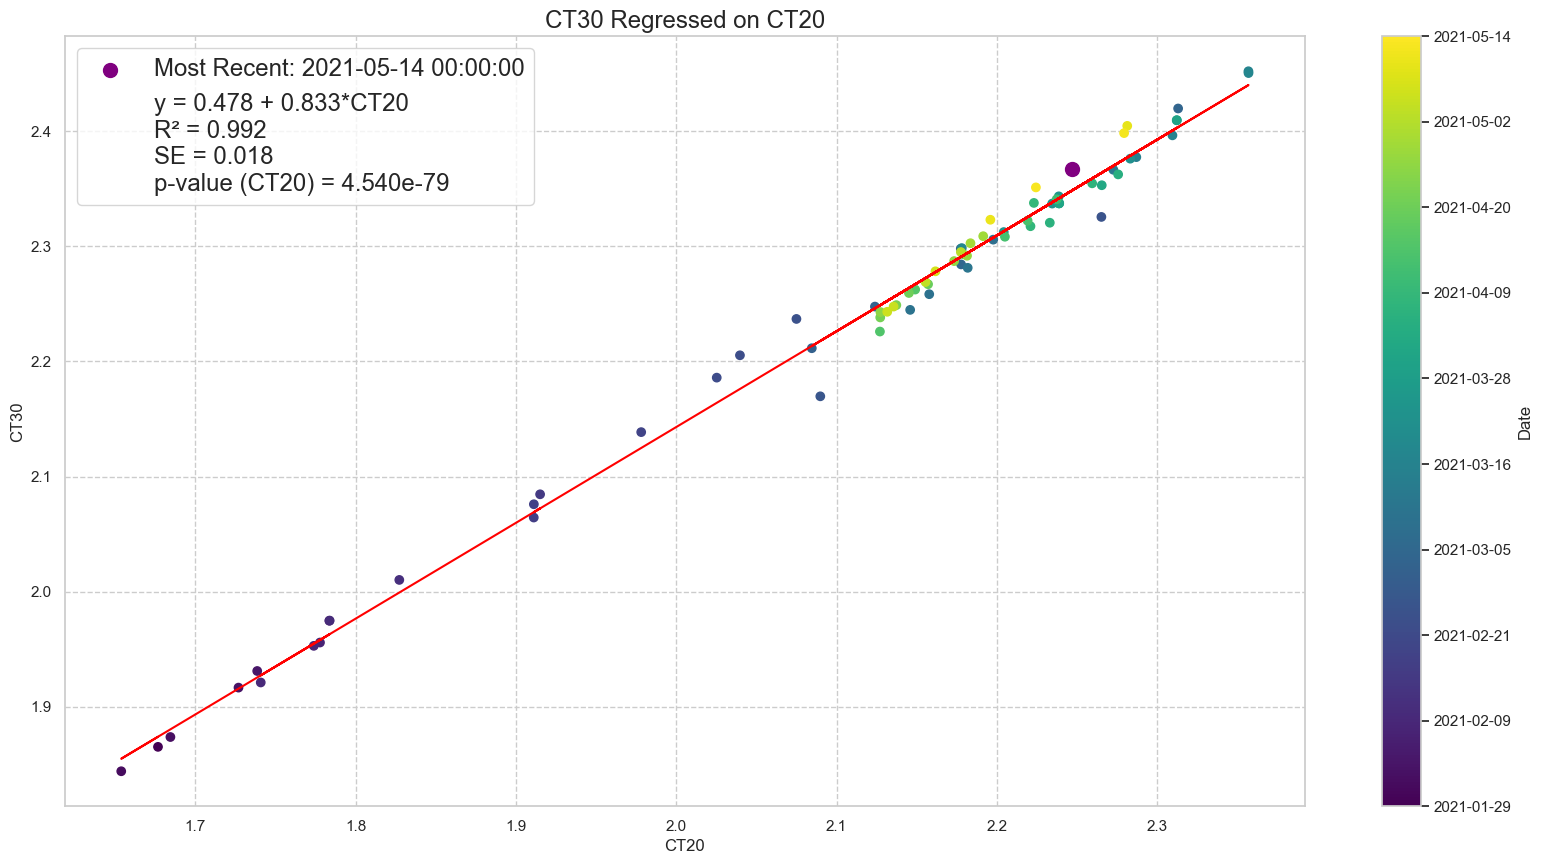

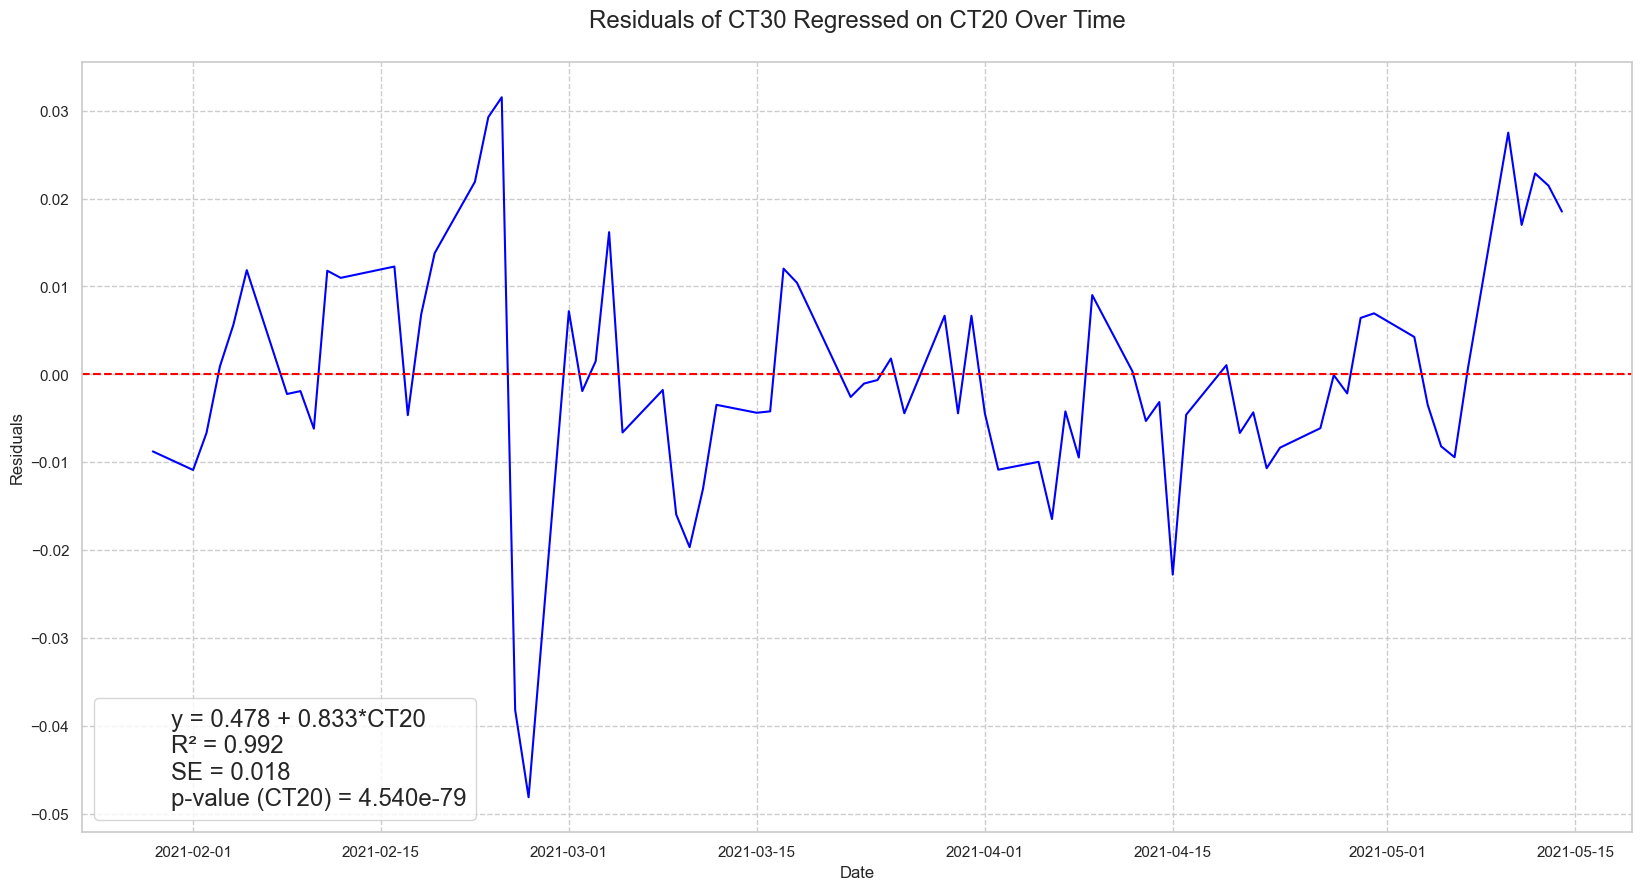

In [294]:
r = run_basic_linear_regression_df(df=ct_yields_df, x_col="CT20", y_col="CT30", date_color_bar=True)
plot_residuals_timeseries(df=ct_yields_df, results=r)

In [171]:
results = ols_hedge_ratio(df=ct_yields_df, x_cols=["CT30", "CT10"], y_col="CT20", last_n_day_regressions=[90])

Regression Result for Last 90 Days:
                            OLS Regression Results                            
Dep. Variable:                   CT20   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.196e+04
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          6.58e-107
Time:                        15:23:48   Log-Likelihood:                 262.15
No. Observations:                  90   AIC:                            -518.3
Df Residuals:                      87   BIC:                            -510.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [170]:
results.resid

1     -0.060515
2     -0.057811
3     -0.062650
4     -0.064224
5     -0.067785
         ...   
923   -0.006179
924   -0.007236
925   -0.003378
926   -0.003577
927    0.000782
Length: 927, dtype: float64